# Group Splitter

Train the group splitter with the updated pipeline structure.

In [1]:
from pathlib import Path
from pioneerml.common.evaluation.plots.loss import LossCurvesPlot
from pioneerml.common.zenml import load_step_output
from pioneerml.common.zenml import utils as zenml_utils
from pioneerml.pipelines.training import group_splitting_pipeline
PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)


Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).


In [2]:
# Build aligned parquet/probability inputs.
# Expected prediction shard naming: ml_output_XXX_preds.parquet
data_dir = Path(PROJECT_ROOT) / "data"
main_paths = sorted(data_dir.glob("ml_output_*.parquet"))
probs_dir = data_dir / "inference_outputs" / "group_classifier"
# Example: uncomment to select a smaller subset
# main_paths = main_paths[:1]
paired = []
missing_prob_paths = []
for main_path in main_paths:
    pred_path = probs_dir / main_path.name.replace(".parquet", "_preds.parquet")
    if pred_path.exists():
        paired.append((str(main_path), str(pred_path)))
    else:
        missing_prob_paths.append(str(pred_path))
if not paired:
    raise RuntimeError(
        "No aligned parquet/prediction pairs found. "
        "Run group-classifier inference first to generate *_preds.parquet files."
    )
if missing_prob_paths:
    print(f"Warning: missing {len(missing_prob_paths)} prediction shard(s); skipping those files.")
parquet_paths = [p for p, _ in paired]
group_probs_parquet_paths = [p for _, p in paired]
print(f"Using {len(parquet_paths)} shard(s) for group-splitter training.")


Using 1 shard(s) for group-splitter training.


In [3]:
# Run the pipeline
pipeline_config = {
    "loader": {"config_json": {"time_window_ns": 1.0}},
    "hpo": {
        "enabled": True,
        "n_trials": 1,
        "max_epochs": 2,
        "batch_size": [1, 2],
        "storage": f"sqlite:///{PROJECT_ROOT}/.optuna/group_splitter_hpo.db",
    },
    "train": {"max_epochs": 2},
    "export": {
        "prefer_cuda": True,
        "export_dir": str(PROJECT_ROOT / "trained_models" / "groupsplitter"),
    },
}
run = group_splitting_pipeline.with_options(enable_cache=False)(
    parquet_paths=parquet_paths,
    group_probs_parquet_paths=group_probs_parquet_paths,
    pipeline_config=pipeline_config,
)
trained_module = load_step_output(run, "train_group_splitter")
hpo_params = load_step_output(run, "tune_group_splitter")
metrics = load_step_output(run, "evaluate_group_splitter")
export = load_step_output(run, "export_group_splitter")
print("hpo_params:", hpo_params)
if trained_module is not None:
    print("train_epoch_loss_history:", list(trained_module.train_epoch_loss_history))
    print("val_epoch_loss_history:", list(trained_module.val_epoch_loss_history))
    print("train_step_count:", len(trained_module.train_loss_history))
    print("val_step_count:", len(trained_module.val_loss_history))
print("metrics:", metrics)
print("export:", export)


Initiating a new run for the pipeline: group_splitting_pipeline.
Caching is disabled by default for group_splitting_pipeline.
Using user: default
Using stack: default
  deployer: default
  artifact_store: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step load_group_splitter_dataset has started.
Step load_group_splitter_dataset has finished in 0.479s.
Step tune_group_splitter has started.


[I 2026-02-07 22:03:07,442] Using an existing study with name 'group_splitter_hpo' instead of creating a new one.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
You are using a CUDA device ('NVIDIA GeForce RTX 5070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupSplitter     │ 87.3 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 87.3 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 87.3 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 21                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=2` reached.


[I 2026-02-07 22:04:23,102] Trial 23 finished with value: 0.028411269720353 and parameters: {'lr': 0.0010433741576340153, 'weight_decay': 0.0008730519167130808, 'batch_size': 2, 'heads': 2, 'hidden': 84, 'layers': 1, 'dropout': 0.2597515083278362}. Best is trial 22 with value: 0.025572360190169383.


Step tune_group_splitter has finished in 1m16s.
Step train_group_splitter has started.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupSplitter     │ 83.2 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 83.2 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 83.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 21                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=2` reached.


[train_group_splitter] No materializer is registered for type <class 'pioneerml.common.training.lightning.GraphLightningModule'>, so the default Pickle materializer was used. Pickle is not production ready and should only be used for prototyping as the artifacts cannot be loaded when running with a different Python version. Please consider implementing a custom materializer for type <class 'pioneerml.common.training.lightning.GraphLightningModule'> according to the instructions at https://docs.zenml.io/concepts/artifacts/materializers
Step train_group_splitter has finished in 1m26s.
Step evaluate_group_splitter has started.
Step evaluate_group_splitter has finished in 4.435s.
Step export_group_splitter has started.
Step export_group_splitter has finished in 1.530s.
Pipeline run has finished in 2m57s.
hpo_params: {'lr': 0.0010638328023692828, 'weight_decay': 0.000942229107889305, 'batch_size': 2, 'study_name': 'group_splitter_hpo', 'storage': 'sqlite:////workspace/.optuna/group_splitter

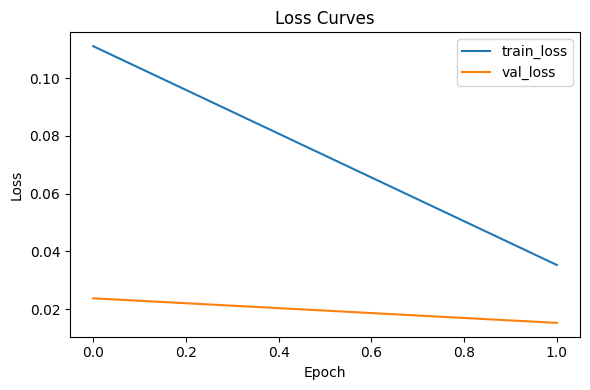

In [4]:
# Plot loss curves
if trained_module is None:
    raise RuntimeError("No trained module loaded from pipeline run.")
LossCurvesPlot().render(trained_module, show=True)
